In [905]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3 as pm
import scipy.stats as sps
import arviz as az

sns.set()

In [906]:
### naked statistics 131 ###

df = pd.DataFrame({'marathon' : [157,11],
                  'sausage' : [211,21]},index=['mu','std'])

df

,marathon,sausage
mu,157,211
std,11,21


In [907]:
size = 1000
samples_marathon = sps.norm.rvs(df.loc['mu','marathon'],df.loc['std','marathon'],size)
samples_sausage = sps.norm.rvs(df.loc['mu','sausage'],df.loc['std','sausage'],size)
samples = pd.DataFrame({'marathon' : samples_marathon,'sausage' : samples_sausage},columns=['marathon','sausage'])

In [908]:
samples

,marathon,sausage
0,156.122287,183.539504
1,168.629191,204.250334
2,137.099918,208.089079
3,150.221766,219.312193
4,147.322475,189.491680
...,...,...
995,160.949912,227.571211
996,158.307834,237.756921
997,153.965315,216.547128
998,163.791804,196.154582


In [909]:
#### assume both samples come from marathon runners ####
## so we use mean and std from marathon population to compute Z-score ##
samples['Z_score_marathon'] = (samples['marathon'] - samples['marathon'].mean()) / samples['marathon'].std()
samples['Z_score_sausage'] = (samples['sausage'] - samples['marathon'].mean()) / samples['marathon'].std()
samples

,marathon,sausage,Z_score_marathon,Z_score_sausage
0,156.122287,183.539504,-0.033714,2.433876
1,168.629191,204.250334,1.091926,4.297882
2,137.099918,208.089079,-1.745755,4.643374
3,150.221766,219.312193,-0.564770,5.653471
4,147.322475,189.491680,-0.825710,2.969581
...,...,...,...,...
995,160.949912,227.571211,0.400779,6.396795
996,158.307834,237.756921,0.162989,7.313524
997,153.965315,216.547128,-0.227845,5.404611
998,163.791804,196.154582,0.656554,3.569252


(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          2.,   8.,   9.,  17.,  29.,  49.,  57.,  72.,  74.,  82.,  95.,
        102.,  79.,  76.,  69.,  45.,  40.,  32.,  24.,  14.,  11.,   4.,
          5.,   3.,   1.,   0.,   0.,   0.]),
 array([100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160,
        165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225,
        230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290,
        295]),
 <BarContainer object of 39 artists>)

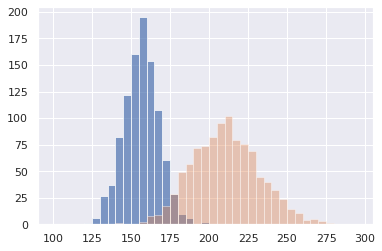

In [910]:
plt.hist(samples.marathon,alpha=0.7,bins=np.arange(100,300,5))
plt.hist(samples.sausage,alpha=0.4,bins=np.arange(100,300,5))

In [911]:
samples_stats = samples.agg(['mean','std'])
samples_stats

,marathon,sausage,Z_score_marathon,Z_score_sausage
mean,156.496880,210.740336,1.207923e-16,4.881991
std,11.110928,21.251277,1.000000e+00,1.912646


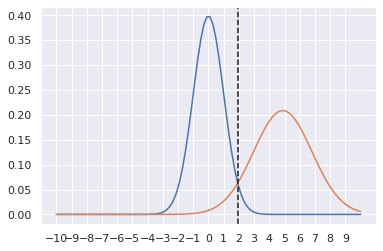

In [912]:
x_vals = np.linspace(-10,10,100)

Z_dist_marathon = pd.Series(sps.norm.pdf(x_vals,samples_stats.loc['mean','Z_score_marathon'],
                              samples_stats.loc['std','Z_score_marathon']))

Z_dist_sausage = pd.Series(sps.norm.pdf(x_vals,samples_stats.loc['mean','Z_score_sausage'],
                              samples_stats.loc['std','Z_score_sausage']))

plt.plot(x_vals,Z_dist_marathon)
plt.plot(x_vals,Z_dist_sausage)
plt.axvline(1.96,ls='dashed',color='k')
_=plt.xticks(range(-10,10,1))

In [913]:
p_s = np.linspace(1e-5,1-1e-5,1000)
### value for cumulative probability <= q ###

ppf_marathon = pd.Series(sps.norm.ppf(p_s,samples_stats.loc['mean','Z_score_marathon'],
                              samples_stats.loc['std','Z_score_marathon']))

ppf_sausage = pd.Series(sps.norm.ppf(p_s,samples_stats.loc['mean','Z_score_sausage'],
                              samples_stats.loc['std','Z_score_sausage']))



In [914]:
print ( (ppf_marathon > 1.96).sum() / len(ppf_marathon) )
print ( (ppf_sausage <= 1.96).sum() / len(ppf_sausage) )

0.025
0.064


In [915]:
combined_stats = combined_samples.agg(['mean','std'])
combined_stats

,weight,type
mean,184.009584,0.500000
std,31.808963,0.500001


In [916]:
# is difference significant ? #
# null hypothesis : samples come from same population #
# if p < 0.05, reject null hypothesis #
sps.ttest_ind(samples['marathon'],samples['sausage'])

Ttest_indResult(statistic=-71.52982735825836, pvalue=0.0)

In [917]:
x_vals = np.linspace(150,160,20)
# p value for whether sample mean is likely to be equal to given value (population mean) #
# Null hypothesis : population mean is the given value #
# if p_value < 0.05, we reject the null hypothesis #
# p_value is the probability of getting a result as extreme as the obtained if the null hypothesis is true # 
p_values = sps.ttest_1samp(samples['marathon'],x_vals)

Text(0.5, 0, 'true mean')

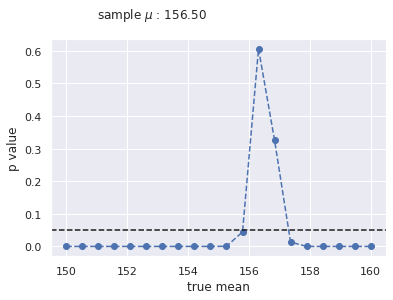

In [918]:
plt.plot(x_vals,p_values[1],'o--')
plt.axhline(0.05,ls='dashed',color='k')
plt.text(151,0.7, r'sample $\mu$ : {:.2f}'.format(samples_stats.loc['mean','marathon']))
plt.ylabel('p value')
plt.xlabel('true mean')

# reject null hypothesis when p < 0.05, cases below dashed line #

In [919]:
x_vals

array([150.        , 150.52631579, 151.05263158, 151.57894737,
       152.10526316, 152.63157895, 153.15789474, 153.68421053,
       154.21052632, 154.73684211, 155.26315789, 155.78947368,
       156.31578947, 156.84210526, 157.36842105, 157.89473684,
       158.42105263, 158.94736842, 159.47368421, 160.        ])

In [920]:
#### example from datascience on hours of sleep. Done by significance testing and bayes ####
####  SIGNIFICANCE TESTING ####

# null hypothesis : sample mean == pop mean #
# if population sd is unknown, then the formula for std error becomes pop_sd / (sample_sd / sqrt(n-1))

def z_score(sample_mean,pop_mean,n,pop_sd):
    return (sample_mean - pop_mean) / (pop_sd / np.sqrt(n))

def p_value(z):
    return sps.norm.cdf(z,0,1)


#z = z_score(x_vals,samples_stats.loc['mean','marathon'],10,samples_stats.loc['std','marathon'])

#https://towardsdatascience.com/statistical-significance-hypothesis-testing-the-normal-curve-and-p-values-93274fa32687

sleep_pop_mean = 7.02
sleep_sample_mean = 6.9
sleep_sample_std = 0.84
sleep_sample_size = 202

z = z_score(sleep_sample_mean,sleep_pop_mean,sleep_sample_size,sleep_sample_std)
print ('z-SCORE : ',z)
print ('p-value : ',p_value(z))
print ('1 - p-value : ', 1 - p_value(z))

z-SCORE :  -2.0303814862216862
p-value :  0.021158888530490534
1 - p-value :  0.9788411114695095


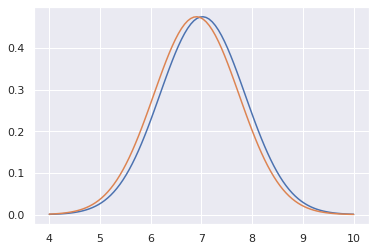

In [921]:
x_vals = np.linspace(4,10,100)
sleep_pop = sps.norm.pdf(x_vals,sleep_pop_mean,sleep_sample_std)
sleep_sample = sps.norm.pdf(x_vals,sleep_sample_mean,sleep_sample_std)
plt.plot(x_vals,sleep_pop)
plt.plot(x_vals,sleep_sample)

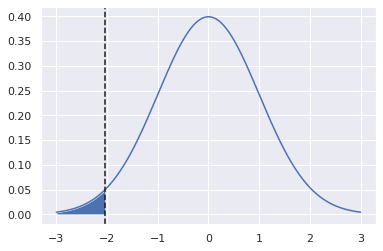

In [922]:
x_vals = np.linspace(-3,3,1000)
z_dist = sps.norm.pdf(x_vals,0,1)
plt.plot(x_vals,z_dist)
plt.axvline(z,ls='dashed',color='k')
plt.fill_between(x_vals[x_vals <= z], 0,z_dist[x_vals <= z])

[0.0013499  0.00137676 0.0014041  0.00143194 0.00146029 0.00148914
 0.00151852 0.00154842 0.00157886 0.00160984 0.00164138 0.00167348
 0.00170615 0.00173939 0.00177323 0.00180766 0.00184271 0.00187836
 0.00191465 0.00195157 0.00198913 0.00202735 0.00206624 0.0021058
 0.00214605 0.00218699 0.00222864 0.00227101 0.00231411 0.00235794
 0.00240253 0.00244788 0.002494   0.0025409  0.00258861 0.00263711
 0.00268644 0.0027366  0.00278761 0.00283947 0.00289219 0.0029458
 0.00300031 0.00305572 0.00311205 0.00316931 0.00322752 0.00328669
 0.00334684 0.00340797 0.0034701  0.00353325 0.00359743 0.00366266
 0.00372894 0.0037963  0.00386474 0.00393429 0.00400496 0.00407676
 0.00414971 0.00422383 0.00429913 0.00437563 0.00445334 0.00453228
 0.00461247 0.00469392 0.00477666 0.00486069 0.00494603 0.00503271
 0.00512074 0.00521014 0.00530092 0.00539311 0.00548672 0.00558177
 0.00567828 0.00577627 0.00587576 0.00597676 0.0060793  0.0061834
 0.00628907 0.00639634 0.00650522 0.00661574 0.00672791 0.0068417

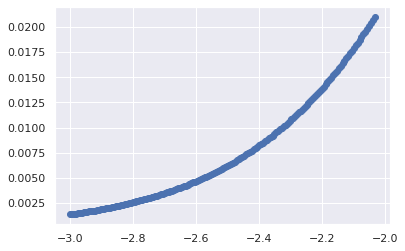

In [923]:
cdf = sps.norm.cdf(x_vals,0,1)
plt.plot(x_vals[x_vals <= z],cdf[x_vals <= z],'o--')
print (cdf[x_vals <= z])

(array([0.02032336, 0.11177846, 0.29468866, 0.45727551, 0.42679048,
        0.44711384, 0.19307188, 0.04064671, 0.05080839, 0.01016168]),
 array([4.72529017, 5.21246315, 5.69963614, 6.18680912, 6.67398211,
        7.16115509, 7.64832808, 8.13550106, 8.62267405, 9.10984703,
        9.59702002]),
 <BarContainer object of 10 artists>)

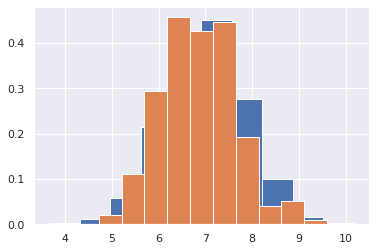

In [924]:
population_sleep = np.random.normal(sleep_pop_mean,sleep_sample_std,10000)
sample_sleep = np.random.normal(sleep_sample_mean,sleep_sample_std,sleep_sample_size)

plt.hist(population_sleep,density=True)
plt.hist(sample_sleep,density=True)

<AxesSubplot:>

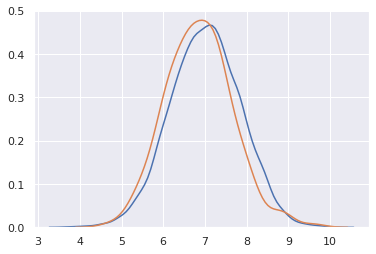

In [925]:
ax = sns.kdeplot(population_sleep)
sns.kdeplot(sample_sleep,ax=ax)

In [926]:
with pm.Model() as model:
    mu = pm.Normal('mu',mu=sleep_pop_mean,sd=sleep_sample_std,shape=2)
    sd = pm.Uniform('sd',0,2,shape=2)

    obs_A = pm.Normal('obs_A',mu=mu[0],sd=sd[0],observed=population_sleep)
    obs_B = pm.Normal('obs_B',mu=mu[1],sd=sd[1],observed=sample_sleep)

    diff = pm.Deterministic('diff',mu[1] - mu[0])
    rel = pm.Deterministic('rel',(mu[1] / mu[0]) - 1)
    
    trace = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


        mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
mu[0]  7.016  0.009     7.002      7.030      0.000    0.000    3531.0   
mu[1]  6.859  0.057     6.767      6.948      0.001    0.001    2650.0   
sd[0]  0.841  0.006     0.830      0.849      0.000    0.000    3713.0   
sd[1]  0.799  0.040     0.735      0.862      0.001    0.000    3500.0   
diff  -0.158  0.058    -0.246     -0.061      0.001    0.001    2717.0   
rel   -0.022  0.008    -0.035     -0.009      0.000    0.000    2716.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
mu[0]  3531.0    3524.0    1401.0    1.0  
mu[1]  2644.0    2664.0    1585.0    1.0  
sd[0]  3704.0    3719.0    1396.0    1.0  
sd[1]  3394.0    3584.0    1498.0    1.0  
diff   2637.0    2719.0    1640.0    1.0  
rel    2637.0    2721.0    1640.0    1.0  


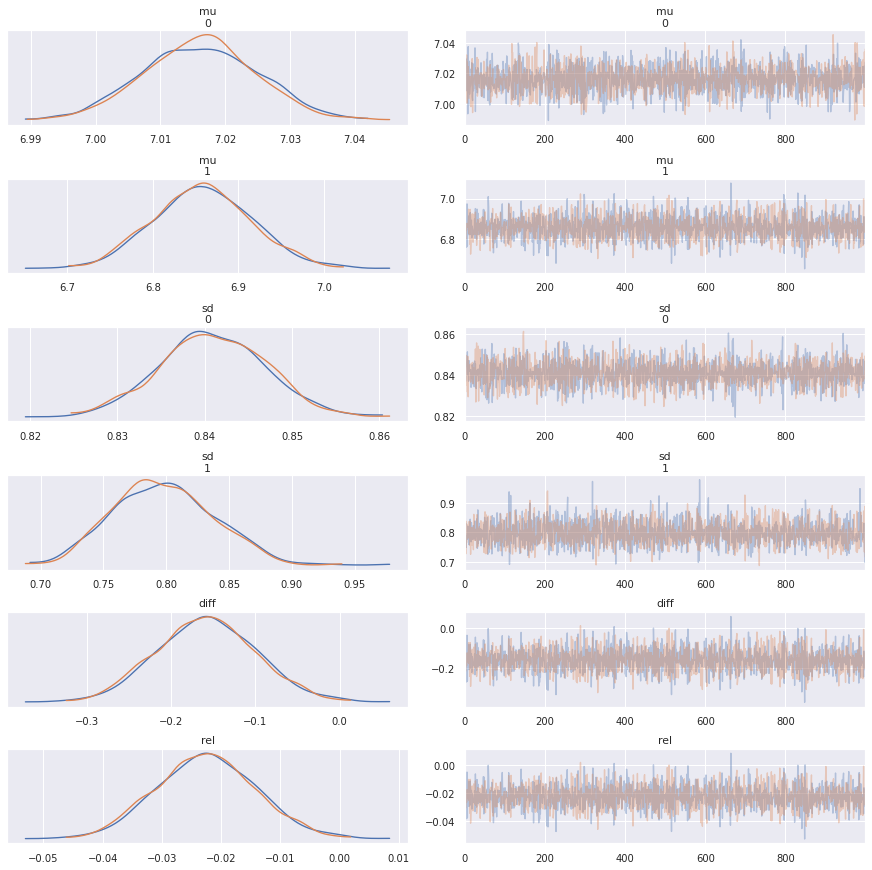

In [927]:
with model:
    print (az.summary(trace,hdi_prob=0.89))
    pm.plot_trace(trace)

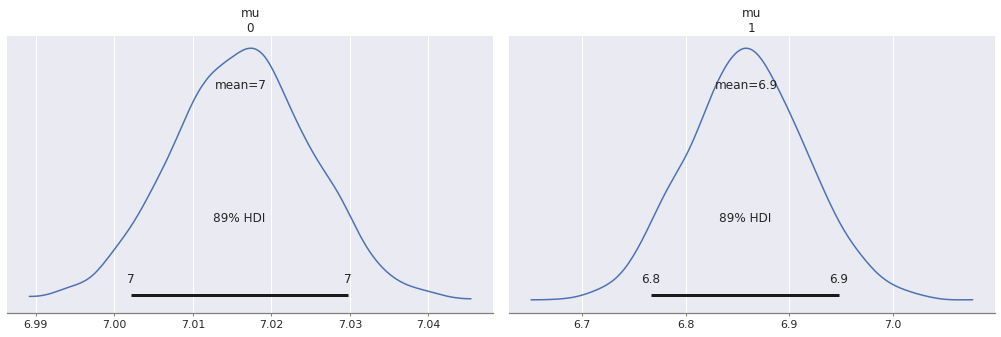

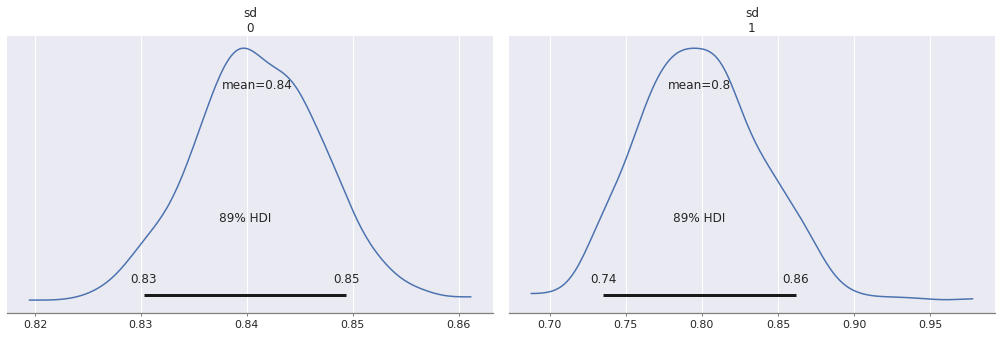

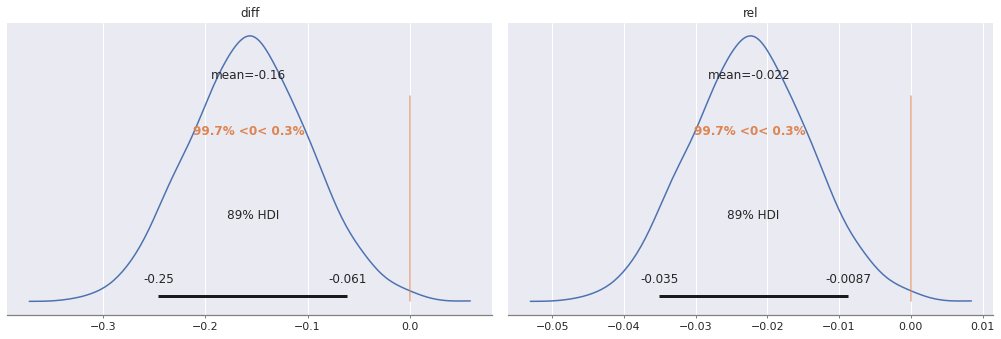

In [928]:
with model:
    az.plot_posterior(data=trace,hdi_prob=0.89,var_names=['mu'])
    az.plot_posterior(data=trace,hdi_prob=0.89,var_names=['sd'])

    az.plot_posterior(data=trace,hdi_prob=0.89,var_names=['diff','rel'],ref_val=0)